In [2]:
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as opt
import torch.utils.data as data
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import os
import sys
import pyarrow
import pickle
import math
import random

The existing code you have is set up for predicting exact stock price values (a regression problem) using a LSTM-based model in PyTorch, while the reference code is for predicting whether the stock price goes up or down (a binary classification problem) using another LSTM-based model. 

In [54]:
# retreive stock data
path = '/Users/hp/SAD_Finance/stock_data_sp500_2016_2018.parquet'
df = pd.read_parquet(path)

#compute daily market price mean(stock_issued * stock_price)
df.reset_index(inplace=True)
df['Date'] = df['Date'].dt.date
df['value'] = df.Close * df.Volume
daily = df.groupby('Date').agg({'value': 'sum', 'Volume': 'sum'})
daily['price'] = daily.value / daily.Volume

# calculate daily price change
daily['price_change'] = daily['price'].diff()
daily.dropna(inplace=True)

# assign labels: 1 if the price goes up, else 0
daily['label'] = np.where(daily['price_change'] > 0, 1, 0)
daily

,value,Volume,price,price_change,label
Date,,,,,
2016-01-05,9.884959e+10,2.547937e+09,38.795938,0.137461,1
2016-01-06,1.152943e+11,2.986486e+09,38.605324,-0.190613,0
2016-01-07,1.320685e+11,3.511790e+09,37.607178,-0.998146,0
2016-01-08,1.117577e+11,3.106335e+09,35.977341,-1.629837,0
2016-01-11,1.113588e+11,3.082366e+09,36.127687,0.150346,1
...,...,...,...,...,...
2018-12-21,2.847205e+11,5.484714e+09,51.911638,0.173065,1
2018-12-24,9.959186e+10,2.011446e+09,49.512574,-2.399064,0
2018-12-26,1.583556e+11,3.103169e+09,51.030299,1.517726,1


In [55]:
# train, val, test split
def time_series_split(data, val_size=0.2, test_size=0.2):
    if type(data) != np.ndarray:
        data = np.array(data)
    
    split1 = int(len(data) * (1 - test_size))
    split2 = int(split1 * (1 - val_size))
    train, val, test = np.split(data, [split2, split1])
    
    return train.reshape(-1,1), val.reshape(-1,1), test.reshape(-1,1)

In [81]:
# This setup is for sequence to sequence prediction
# With this setup, forecasting period will be loceked to the same length as the lookback period
# Should discuss whether using this one-step-ahead forecast make sense
def create_dataset(data, lookback):
    n_data, n_feat = data.shape
    X = np.empty((n_data-lookback, lookback, n_feat))
    y = np.empty((n_data-lookback, lookback, n_feat))

    for i in range(n_data-lookback):
        feature = data[i:i+lookback]
        target = data[i+1:i+lookback+1]
        X[i] = feature
        y[i] = target
    return torch.tensor(X), torch.tensor(y)

In [100]:
class LSTMClassifier(nn.Module):
    def __init__(self, input_dim, n_nodes, output_dim=1, n_layers=1):
        # input is in format (batch_size, seq_len, num_features)
        super().__init__()
        self.input_dim = input_dim
        self.n_nodes = n_nodes
        self.output_dim = output_dim
        self.n_layers = n_layers
        
        # Define LSTM layer(s)
        self.lstm = nn.LSTM(self.input_dim, self.n_nodes, self.n_layers, batch_first=True)
        
        # Define the output layer
        self.linear = nn.Linear(self.n_nodes, output_dim)
        
    def forward(self, x):
        # output is in format (batch_size, seq_len, output_dim)
        out, _ = self.lstm(x)
        out = out[:, -1, :]  # We only take the last output for each sequence
        pred = self.linear(out)
        return pred

This code first calculates the price change and assigns labels based on whether the price goes up or down. Then it creates datasets for the model based on these labels. The LSTM model is modified to be a classifier, and the loss function is changed to cross-entropy loss. The labels are also converted to long type, because nn.CrossEntropyLoss() requires long type. 

In [101]:
# create train, val, test datasets
labels = daily['label'].values
train, val, test = time_series_split(labels)

scaler = MinMaxScaler((0,1))
scaler.fit(train)
norm_train = scaler.transform(train)
norm_val = scaler.transform(val)
norm_test = scaler.transform(test)

lookback = 1
# create datasets for the model
X_train, y_train = create_dataset(train, lookback)
X_val, y_val = create_dataset(val, lookback)
X_test, y_test = create_dataset(test, lookback)

print(X_train.shape, y_train.shape)

torch.Size([479, 1, 1]) torch.Size([479, 1, 1])


In [102]:
# Convert labels to LongTensor
y_train = y_train.type(torch.LongTensor)
y_val = y_val.type(torch.LongTensor)
y_test = y_test.type(torch.LongTensor)

# Convert inputs to FloatTensor
X_train = X_train.float()
X_val = X_val.float()
X_test = X_test.float()

# Convert labels to LongTensor
y_train = y_train.long()
y_val = y_val.long()
y_test = y_test.long()

In [103]:
# Hyperparameters
#lookback = 10  # define how many timesteps to lookback
input_dim = 1  # number of input features
n_nodes = 64  # number of nodes in LSTM layer
n_layers = 2  # number of LSTM layers
output_dim = 2  # number of output features
lr = 0.001  # learning rate
n_epochs = 100  # number of epochs

# Instantiate the model, loss function and optimizer
model = LSTMClassifier(input_dim, n_nodes, output_dim, n_layers)
loss_fn = nn.CrossEntropyLoss() #for binary classfication
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=10)

In [108]:
# Training loop
for epoch in range(n_epochs):
    model.train()
    optimizer.zero_grad()
    
    for feat, label in loader:
        y_pred = model(feat)
        #print(y_pred.shape)  # Should print something like: torch.Size([10, 2])
        label = label.squeeze()  # remove dimensions of size 1
        #print(label.shape)  # Should print something like: torch.Size([10])
        loss = loss_fn(y_pred, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()    

    if epoch % 10 == 0:
        print(f"Epoch: {epoch}, Training Loss: {loss.item()}")

Epoch: 0, Training Loss: 0.7832258343696594
Epoch: 10, Training Loss: 0.6869153380393982
Epoch: 20, Training Loss: 0.7322962284088135
Epoch: 30, Training Loss: 0.643356204032898
Epoch: 40, Training Loss: 0.6536702513694763
Epoch: 50, Training Loss: 0.675787627696991
Epoch: 60, Training Loss: 0.7416876554489136
Epoch: 70, Training Loss: 0.6877607107162476
Epoch: 80, Training Loss: 0.6482982635498047
Epoch: 90, Training Loss: 0.6700018644332886


In [116]:
# Validation loop
for epoch in range(n_epochs):
    model.eval()  # Set the model to evaluation mode
    val_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for feat, label in loader:  # Assuming you have a separate DataLoader for validation data
            y_pred = model(feat)
            label = label.squeeze()  # Remove extra dimensions if present
            loss = loss_fn(y_pred, label)
            val_loss += loss.item()

            _, predicted = torch.max(y_pred.data, 1)
            total += label.size(0)
            correct += (predicted == label).sum().item()

    val_loss /= len(loader)  # Compute average loss
    val_accuracy = correct / total  # Compute accuracy

    if epoch % 10 == 0:
        print(f"Epoch: {epoch}, Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}")

Epoch: 0, Validation Loss: 0.6745826949675878, Validation Accuracy: 0.5949895615866388
Epoch: 10, Validation Loss: 0.6748506079117457, Validation Accuracy: 0.5949895615866388
Epoch: 20, Validation Loss: 0.6747707811494669, Validation Accuracy: 0.5949895615866388
Epoch: 30, Validation Loss: 0.6745870225131512, Validation Accuracy: 0.5949895615866388
Epoch: 40, Validation Loss: 0.6745210165778796, Validation Accuracy: 0.5949895615866388
Epoch: 50, Validation Loss: 0.6748273223638535, Validation Accuracy: 0.5949895615866388
Epoch: 60, Validation Loss: 0.6747699677944183, Validation Accuracy: 0.5949895615866388
Epoch: 70, Validation Loss: 0.6746668592095375, Validation Accuracy: 0.5949895615866388
Epoch: 80, Validation Loss: 0.6748462778826555, Validation Accuracy: 0.5949895615866388
Epoch: 90, Validation Loss: 0.6746625266969204, Validation Accuracy: 0.5949895615866388


ROC curve illustrates the trade-off between the true positive rate and the false positive rate at various classification thresholds. A good classifier will have a curve that is closer to the top left corner, indicating a higher true positive rate and a lower false positive rate.

In [119]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve

model.eval()

# Generate predictions on the test data
with torch.no_grad():
    outputs = model(X_test)
    _, predicted = torch.max(outputs.data, 1)

# Convert tensor to numpy array for use with sklearn metrics
predicted_np = predicted.numpy()
y_test_np = y_test.numpy().flatten()

# Calculate metrics
accuracy = accuracy_score(y_test_np, predicted_np)
precision = precision_score(y_test_np, predicted_np)
recall = recall_score(y_test_np, predicted_np)
f1 = f1_score(y_test_np, predicted_np)

# To compute AUC-ROC we need to get the probability of the positive class
probabilities = torch.nn.functional.softmax(outputs, dim=1)[:, 1].numpy()

roc_auc = roc_auc_score(y_test_np, probabilities)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"AUC-ROC: {roc_auc}")

Accuracy: 0.5933333333333334
Precision: 0.5714285714285714
Recall: 0.6111111111111112
F1 Score: 0.5906040268456376
AUC-ROC: 0.6082621082621082


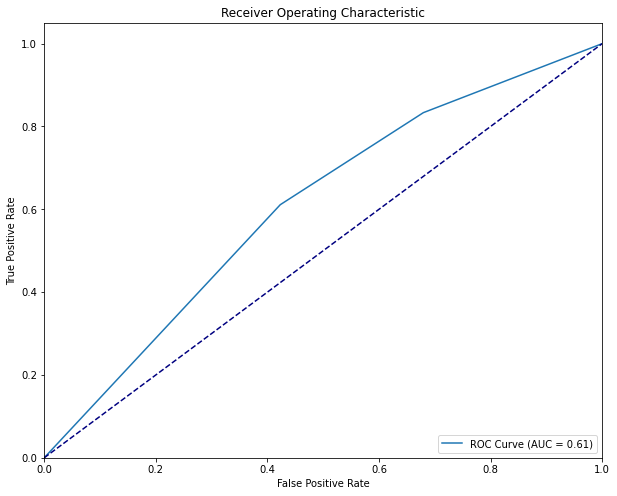

In [120]:
# Plot the ROC curve
fpr, tpr, _ = roc_curve(y_test_np, probabilities)
plt.figure(figsize=(10,8))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()